In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

In [16]:
# Step 1: Data Loading & Preprocessing
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
data = pd.read_csv(url)

# Convert 'Month' to datetime and set as index
data['Month'] = pd.to_datetime(data['Month'])
data.set_index('Month', inplace=True)

# Check for missing values
print("Missing values:\n", data.isnull().sum())

# Handle missing values (if any, interpolate)
data = data.interpolate() if data.isnull().sum().any() else data


Missing values:
 Passengers    0
dtype: int64


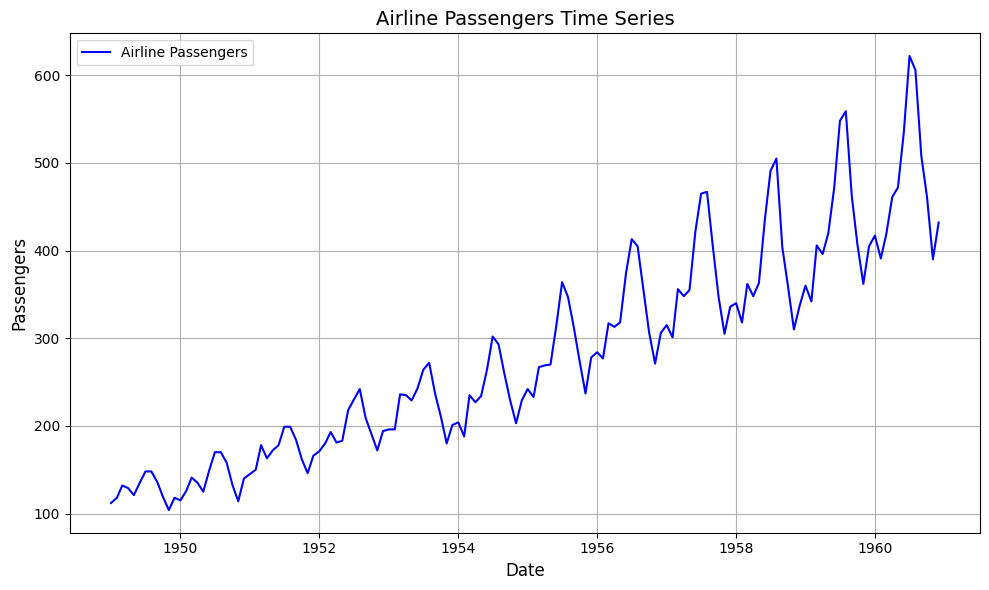

Observation: The time series shows a clear upward trend and annual seasonality (12-month cycles).


In [17]:
# Step 2: Visualization
plt.figure(figsize=(10, 6))
plt.plot(data['Passengers'], label='Airline Passengers', color='blue')
plt.title('Airline Passengers Time Series', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Passengers', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()

# Observation
print("Observation: The time series shows a clear upward trend and annual seasonality (12-month cycles).")

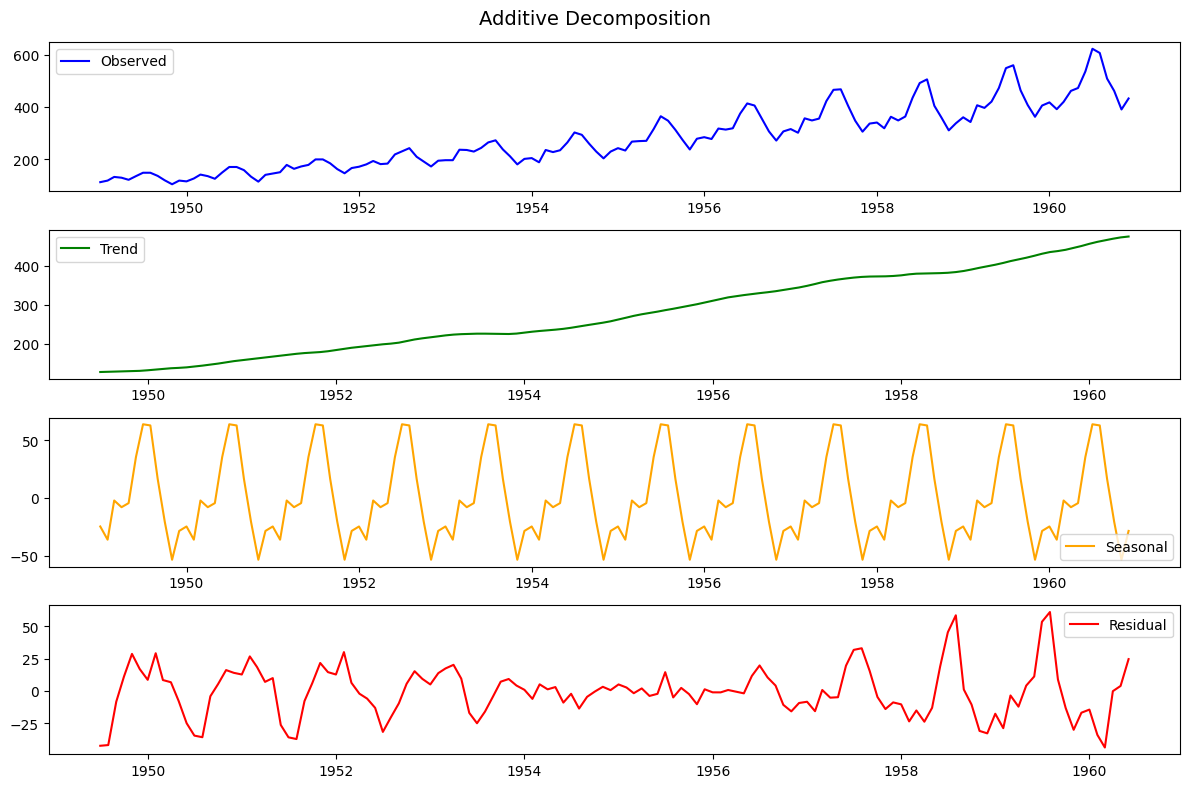

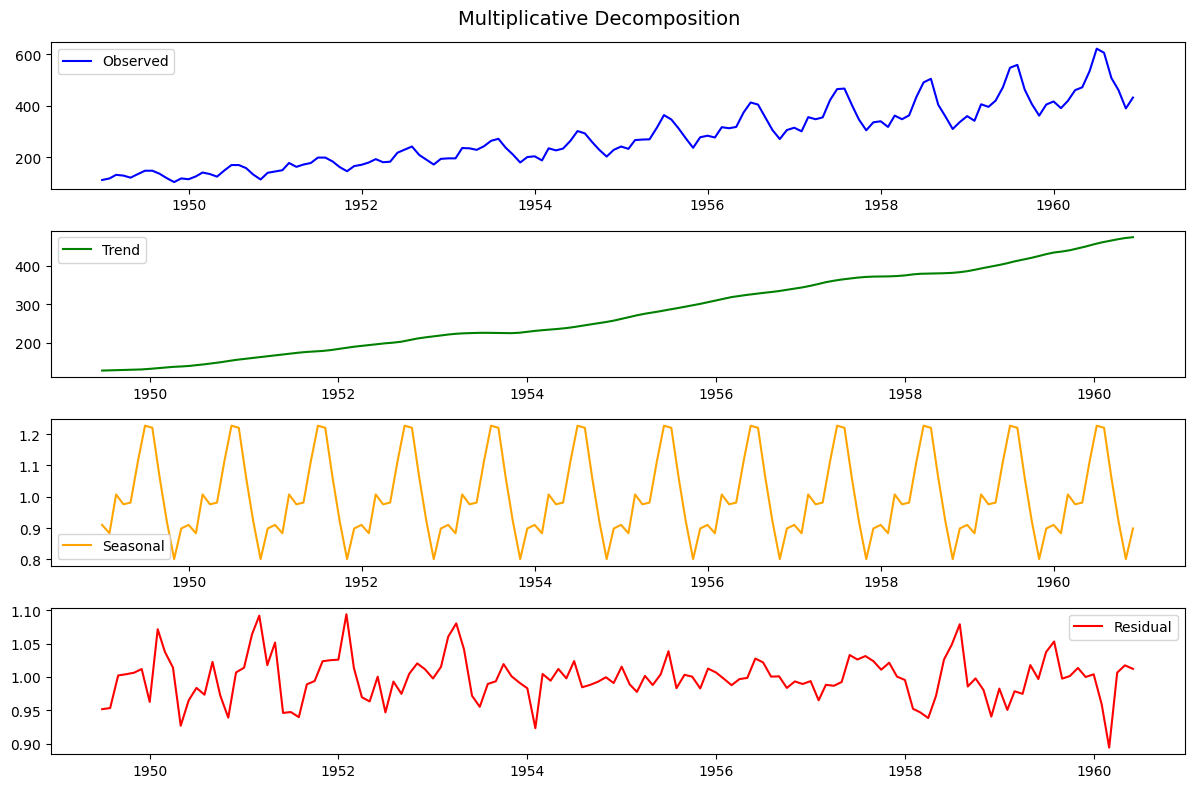

Decomposition Interpretation:
- Trend: Both models show a consistent upward trend.
- Seasonal: Clear 12-month periodicity.
- Residual: Multiplicative residuals are more random, suggesting it fits better due to increasing variance.


In [18]:
# Step 3: Decomposition
# Additive decomposition
add_decomp = seasonal_decompose(data['Passengers'], model='additive', period=12)
# Multiplicative decomposition
mult_decomp = seasonal_decompose(data['Passengers'], model='multiplicative', period=12)

# Plot additive decomposition
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(add_decomp.observed, label='Observed', color='blue')
plt.legend(fontsize=10)
plt.subplot(412)
plt.plot(add_decomp.trend, label='Trend', color='green')
plt.legend(fontsize=10)
plt.subplot(413)
plt.plot(add_decomp.seasonal, label='Seasonal', color='orange')
plt.legend(fontsize=10)
plt.subplot(414)
plt.plot(add_decomp.resid, label='Residual', color='red')
plt.legend(fontsize=10)
plt.suptitle('Additive Decomposition', fontsize=14)
plt.tight_layout()
plt.show()

# Plot multiplicative decomposition
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(mult_decomp.observed, label='Observed', color='blue')
plt.legend(fontsize=10)
plt.subplot(412)
plt.plot(mult_decomp.trend, label='Trend', color='green')
plt.legend(fontsize=10)
plt.subplot(413)
plt.plot(mult_decomp.seasonal, label='Seasonal', color='orange')
plt.legend(fontsize=10)
plt.subplot(414)
plt.plot(mult_decomp.resid, label='Residual', color='red')
plt.legend(fontsize=10)
plt.suptitle('Multiplicative Decomposition', fontsize=14)
plt.tight_layout()
plt.show()

# Interpretation
print("Decomposition Interpretation:")
print("- Trend: Both models show a consistent upward trend.")
print("- Seasonal: Clear 12-month periodicity.")
print("- Residual: Multiplicative residuals are more random, suggesting it fits better due to increasing variance.")


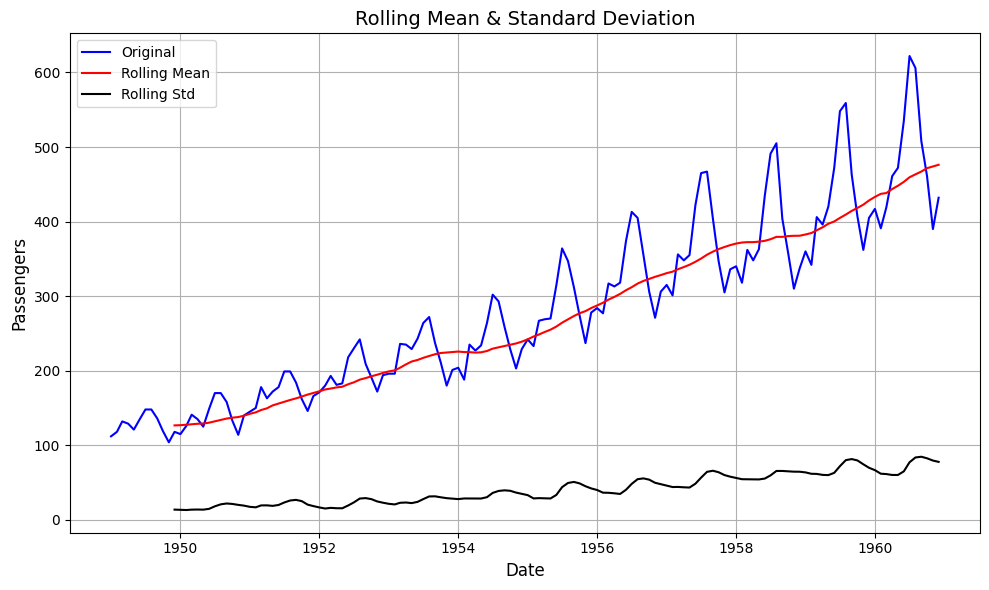

ADF Test Results:
ADF Statistic: 0.815
p-value: 0.992
Critical Values: {'1%': np.float64(-3.4816817173418295), '5%': np.float64(-2.8840418343195267), '10%': np.float64(-2.578770059171598)}
Stationarity Interpretation:
p-value > 0.05, ADF statistic not negative enough. Series is non-stationary.


In [19]:
# Step 4: Stationarity Testing
# Calculate rolling mean and std
rolling_mean = data['Passengers'].rolling(window=12).mean()
rolling_std = data['Passengers'].rolling(window=12).std()

# Plot rolling statistics
plt.figure(figsize=(10, 6))
plt.plot(data['Passengers'], label='Original', color='blue')
plt.plot(rolling_mean, label='Rolling Mean', color='red')
plt.plot(rolling_std, label='Rolling Std', color='black')
plt.title('Rolling Mean & Standard Deviation', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Passengers', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()

# ADF Test
adf_result = adfuller(data['Passengers'])
print('ADF Test Results:')
print(f'ADF Statistic: {adf_result[0]:.3f}')
print(f'p-value: {adf_result[1]:.3f}')
print('Critical Values:', adf_result[4])

# Interpretation
print("Stationarity Interpretation:")
print("p-value > 0.05, ADF statistic not negative enough. Series is non-stationary.")


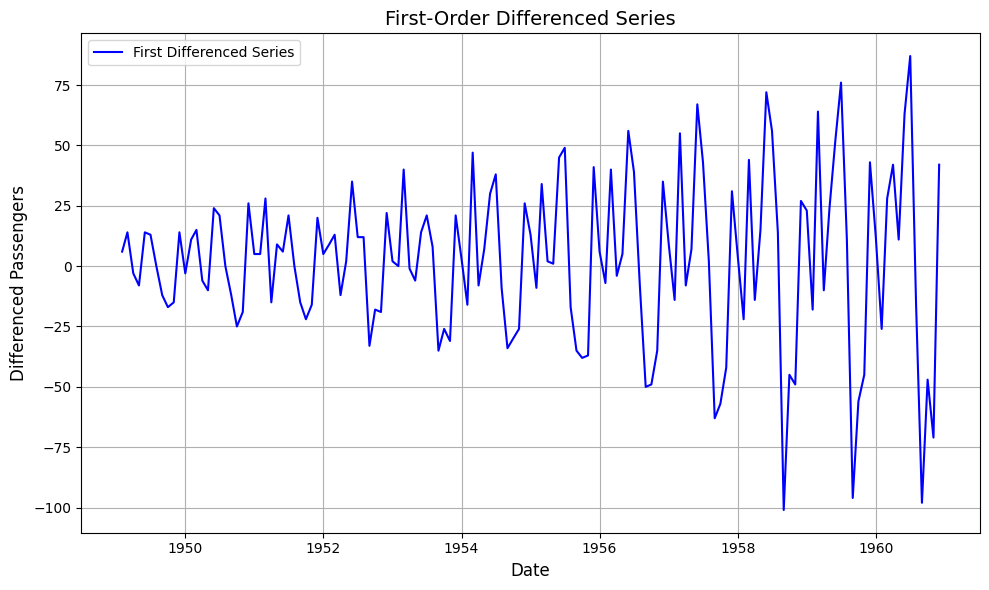

ADF Test Results (Differenced):
ADF Statistic: -2.829
p-value: 0.054
Critical Values: {'1%': np.float64(-3.4816817173418295), '5%': np.float64(-2.8840418343195267), '10%': np.float64(-2.578770059171598)}
Differenced Stationarity Interpretation:
p-value ≈ 0.05, ADF statistic close to 5% critical value. Series is borderline stationary.


In [20]:
# Step 5: Differencing
# First-order differencing
data_diff = data['Passengers'].diff().dropna()

# Plot differenced series
plt.figure(figsize=(10, 6))
plt.plot(data_diff, label='First Differenced Series', color='blue')
plt.title('First-Order Differenced Series', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Differenced Passengers', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()

# ADF Test on differenced series
adf_diff_result = adfuller(data_diff)
print('ADF Test Results (Differenced):')
print(f'ADF Statistic: {adf_diff_result[0]:.3f}')
print(f'p-value: {adf_diff_result[1]:.3f}')
print('Critical Values:', adf_diff_result[4])

# Interpretation
print("Differenced Stationarity Interpretation:")
print("p-value ≈ 0.05, ADF statistic close to 5% critical value. Series is borderline stationary.")


In [21]:
# Step 6: ARIMA Modeling
# Fit ARIMA(1,1,1) model
model = ARIMA(data['Passengers'], order=(1, 1, 1))
model_fit = model.fit()

# Print model summary
print(model_fit.summary())

# Interpretation
print("ARIMA Model Interpretation:")
print("- p-values: AR(1) and MA(1) p-values < 0.05, significant.")
print("- AIC: 1394.683 (from provided summary), baseline for model fit.")
print("- Coefficients: AR(1) = -0.4742, MA(1) = 0.8635, indicating corrective effects.")


                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  144
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -694.341
Date:                Fri, 09 May 2025   AIC                           1394.683
Time:                        16:51:19   BIC                           1403.571
Sample:                    01-01-1949   HQIC                          1398.294
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4742      0.123     -3.847      0.000      -0.716      -0.233
ma.L1          0.8635      0.078     11.051      0.000       0.710       1.017
sigma2       961.9270    107.433      8.954      0.0

Forecast Values:
               Forecast
1961-01-01  475.735059
1961-02-01  454.996073
1961-03-01  464.830415
1961-04-01  460.167010
1961-05-01  462.378378
1961-06-01  461.329756
1961-07-01  461.827008
1961-08-01  461.591213
1961-09-01  461.703026
1961-10-01  461.650005
1961-11-01  461.675148
1961-12-01  461.663225


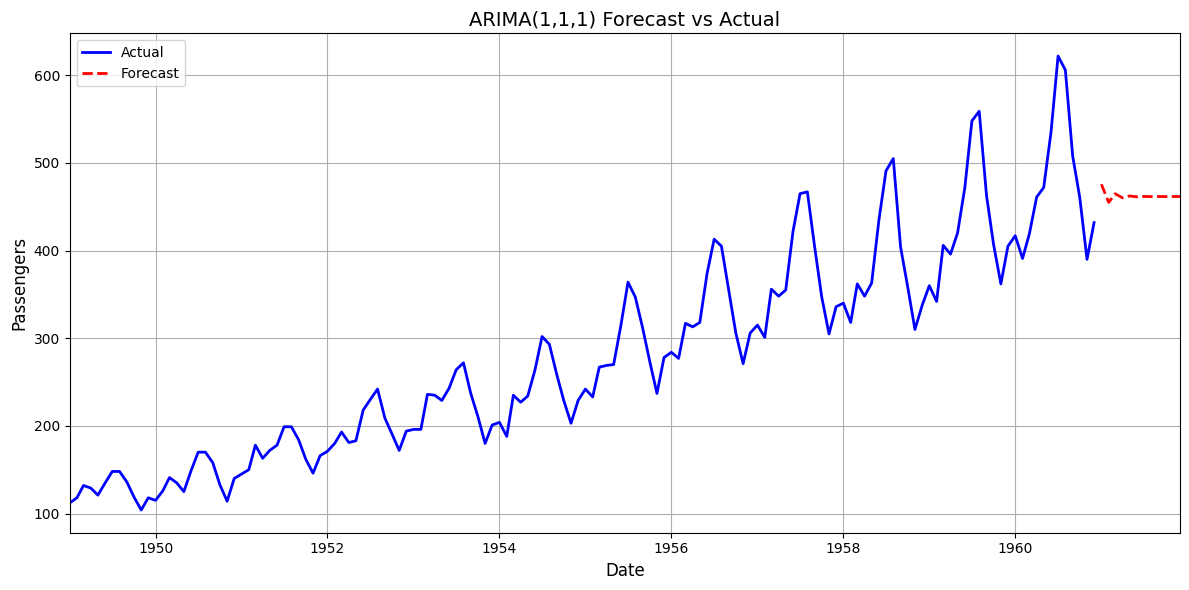

RMSE: 91.23
MAE: 66.24


In [22]:
# Step 7: Forecasting
# Forecast next 12 time steps
forecast = model_fit.forecast(steps=12)
forecast_index = pd.date_range(start=data.index[-1] + pd.offsets.MonthBegin(1),
                              periods=12, freq='MS')

# Create forecast DataFrame
forecast_df = pd.DataFrame({'Forecast': forecast}, index=forecast_index)

# Print forecast data to verify
print("Forecast Values:\n", forecast_df)

# Plot actual data and forecast
plt.figure(figsize=(12, 6))
plt.plot(data['Passengers'], label='Actual', color='blue', linewidth=2)
plt.plot(forecast_df['Forecast'], label='Forecast', color='red', linestyle='--', linewidth=2)
plt.title('ARIMA(1,1,1) Forecast vs Actual', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Passengers', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)
plt.xlim([data.index[0], forecast_index[-1]])  # Extend x-axis to include forecast
plt.tight_layout()
plt.show()

# Evaluate forecast (using last 12 months as test set)
train_size = len(data) - 12
train, test = data['Passengers'][:train_size], data['Passengers'][train_size:]
model_eval = ARIMA(train, order=(1, 1, 1))
model_eval_fit = model_eval.fit()
forecast_eval = model_eval_fit.forecast(steps=12)

# Calculate RMSE and MAE
rmse = np.sqrt(mean_squared_error(test, forecast_eval))
mae = mean_absolute_error(test, forecast_eval)
print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')